In [1]:

!pip install biopython
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
print(np.__version__)

1.23.5


In [10]:
import site
site.getsitepackages()

import sys
# make sure the conda libraries are recognized here
_ = sys.path.append("/opt/modules/i12g/anaconda/envs/jupyterhub/lib/python3.8/site-packages")

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import clip
import csv
import os
import re
from Bio import Entrez, SeqIO
import pandas as pd
from glob import glob, escape
import gzip
#import umap.umap_ as umap

## Visualize an image of Zosteropidae

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

Image to be processed


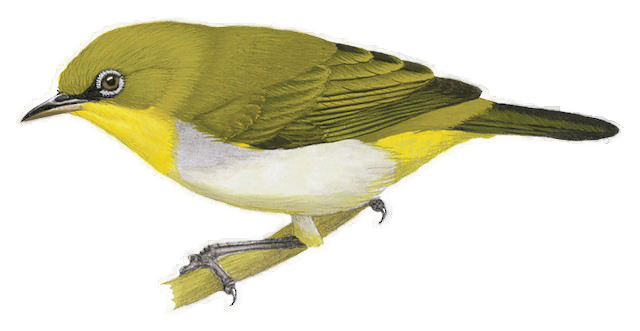



Tensor shape:
torch.Size([1, 3, 224, 224])


In [10]:
# Set up the image file path
image_path = '/s/project/gene2bird/image_data/BoW_plates/Zosteropidae/Yellow-throated_White-eye_Zosterops_metcalfii_153120981.png'

# Load the image
image = Image.open(image_path)
print("Image to be processed")
display(image)

# Pre-process the image
image = preprocess(image).unsqueeze(0).to(device)
print("\n\nTensor shape:")
print(image.shape)


In [11]:
# Image feature extraction
with torch.no_grad():
    image_features = model.encode_image(image)
print(image_features.shape)

torch.Size([1, 512])


In [3]:
# Email address is required for accessing the NCBI database
Entrez.email = "Joshua99@t-online.de"

# Function to retrieve species name from assembly accession
def retrieve_species_name(contig):
    esearch_file = Entrez.esearch(db='assembly', term=contig)
    esearch_record = Entrez.read(esearch_file)
    
    #each IdList only contains a single species so the second for loop isnt needed and since we return inside the first iteration of the for loop, this is semantically the same
    
    birb_name = esearch_record['IdList'][0]       
    es_handle = Entrez.esummary(db='assembly', id=birb_name, report='full')
    es_record = Entrez.read(es_handle)
    result_final = es_record['DocumentSummarySet']['DocumentSummary'][0]['SpeciesName']
    return(result_final)
        

In [5]:
genome_dir = '/s/project/gene2bird/groupA/genome_assemblies_prot_fasta/ncbi-genomes-2023-05-31'
output_file = '/s/project/gene2bird/groupA/annotated_metadata.csv'
# Create a list to store the species and genome assembly mapping
species_genome_mapping = []

# Iterate over files in the genome directory
for root, dirs, files in os.walk(genome_dir):
    for file in files:
        # Match the file pattern
        match = re.search(r'(GCA_\d+\.\d+)', file)
        if match:
            genome_id = match.group(1)
            
            # Get the species name using the retrieve_species_name function
            species_name = retrieve_species_name(genome_id)
            
            # Append the species and genome assembly ID to the mapping list
            species_genome_mapping.append({'species': species_name, 'genome assembly ID': genome_id})



In [63]:
specs = [i["species"] for i in species_genome_mapping]
meta_df = pd.read_csv("/s/project/gene2bird/image_data/METADATA.csv")
sum([s in list(meta_df["scinam"]) for s in specs])



258

In [3]:
df = pd.read_csv("/s/project/gene2bird/image_data/METADATA.csv")
map_df = pd.DataFrame(data = species_genome_mapping).sort_values("species")
map_df.columns = ["scinam", "file_id"]
print(sum([species in list(df["scinam"]) for species in map_df["scinam"]]))



NameError: name 'species_genome_mapping' is not defined

In [64]:
annotated_df = df.merge(map_df, how = "left", on = "scinam")
annotated_df = annotated_df.dropna(subset="file_id")
annotated_df.to_csv(output_file, index=False)

,filenam,scinam,subspecies,family,bownam,md5,color_morph,breeding_status,descriptor,nominate,sex,file_id
14,Ornate_Tinamou_(branickii)_Nothoprocta_ornata_...,Nothoprocta ornata,branickii,Tinamidae,orntin1,c5379808f5d28005650bc5bd0f2f101d1,NaN,NaN,perched,no,male,GCA_013398335.1
23,African_Broadbill_(albigularis)_Smithornis_cap...,Smithornis capensis,albigularis,Calyptomenidae,afrbro1,b1d9b55329647ceedf6106080058b5e01,NaN,NaN,perched,no,male,GCA_013396465.1
24,African_Broadbill_(conjunctus)_Smithornis_cape...,Smithornis capensis,conjunctus,Calyptomenidae,afrbro1,542e80aa4f27322701d42165dd976d7b1,NaN,NaN,perched,no,male,GCA_013396465.1
73,Rufous-breasted_Antthrush_(lasallei)_Formicari...,Formicarius rufipectus,lasallei,Formicariidae,rubant1,3d69dcae2c23b37c3a9109ddfe5701ea1,NaN,NaN,perched,no,male,GCA_013399695.1
108,Eurasian_Blackcap_(heineken)_Sylvia_atricapill...,Sylvia atricapilla,heineken,Sylviidae,blackc1,dc2cb95806810d4fd3ba6a2fe9e0f5901,dark,NaN,perched,no,male,GCA_013398435.1
...,...,...,...,...,...,...,...,...,...,...,...,...
31223,Orange-bellied_Leafbird_(hardwickii)_Chloropsi...,Chloropsis hardwickii,hardwickii,Chloropseidae,orblea1,91ca44adac4d5333abcf8859e42c4f7b1,NaN,NaN,perched,yes,female,GCA_013390065.1
31233,White_Wagtail_(Chinese)_Motacilla_alba_leucops...,Motacilla alba,leucopsis,Motacillidae,whiwag,6533250e0a144eef6e2c113b2574dd361,NaN,NaN,perched,no,female,GCA_013397355.1
31234,White_Wagtail_(Black-backed)_Motacilla_alba_lu...,Motacilla alba,lugens,Motacillidae,whiwag,6c95d76117e527ecf50ab770ee2b11701,NaN,NaN,perched,no,female,GCA_013397355.1
31235,White_Wagtail_(ocularis)_Motacilla_alba_ocular...,Motacilla alba,ocularis,Motacillidae,whiwag,63f65a0b72920116ebc2dabc4e4474e51,NaN,NaN,perched,no,female,GCA_013397355.1


In [7]:
#GPRC5B is goi
Entrez.email = "Joshua99@t-online.de"
files = glob(escape(genome_dir) + "/" + "*faa.gz")
protein_df = {}
genome_dir = '/s/project/gene2bird/groupA/genome_assemblies_prot_fasta/ncbi-genomes-2023-05-31'
n = len(files)
for i, file in enumerate(files):
    name = species_genome_mapping[i]["species"]
    if name == 'Glaucidium brasilianum' or name == 'Ifrita kowaldi':
        with gzip.open(file, 'rt') as f:
            search_terms = [record.id for record in SeqIO.parse(f, "fasta")]
            search = Entrez.efetch(id = search_terms, db = "Protein", retmode = "xml")
            esearch_record = Entrez.read(search)
            genes = [record["GBSeq_definition"] for record in esearch_record]
        protein_df[name] = genes




        


In [10]:
import json
with open("/s/project/gene2bird/groupA/two_missing.json", "w") as outfile:
    json.dump(protein_df, outfile)
    

In [21]:
files = glob(escape(genome_dir) + "/" + "*faa.gz")
search_terms = []
for file in files[0:1]:
    name = species_genome_mapping[i]["species"]
    genes = []
    with gzip.open(file, 'rt') as f:
        search_terms = [record.id for record in SeqIO.parse(f, "fasta")]
print(search_terms[0:20])

            


['NXL69168.1', 'NXL69169.1', 'NXL69170.1', 'NXL69171.1', 'NXL69172.1', 'NXL69173.1', 'NXL69174.1', 'NXL69175.1', 'NXL69176.1', 'NXL69177.1', 'NXL69178.1', 'NXL69179.1', 'NXL69180.1', 'NXL69181.1', 'NXL69182.1', 'NXL69183.1', 'NXL69184.1', 'NXL69185.1', 'NXL69186.1', 'NXL69187.1']


In [30]:
import time

t0 = time.time()


search = Entrez.efetch(id = search_terms, db = "Protein", retmode = "xml")
esearch_record = Entrez.read(search)
prots = [record["GBSeq_definition"] for record in esearch_record]

t1 = time.time()
print(t1- t0)

188.94265699386597


## Extract genome data

## Run CLIP for all bird images

In [11]:
image_dir = '/s/project/gene2bird/image_data/BoW_plates/'
anno_df = pd.read_csv('/s/project/gene2bird/groupA/annotated_metadata.csv')
filenames = list(anno_df["filenam"])
files = glob(escape(image_dir) + "*")
dictus = {}
for i, spec in enumerate([f.split("/")[6] for f in files]):
    dictus[spec] = i

path_to_png = []
for i in range(len(anno_df)):
    fam = anno_df.loc[i]["family"]
    directory = files[dictus[fam]]
    path_to_png.append(directory + "/" + anno_df.loc[i]["filenam"])
path_to_png = np.unique(path_to_png)


In [9]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


# Dict to store the embeddings
embeddings = {}

# Iterate over the image files
for i, image_path in enumerate(path_to_png):
        # Preprocess the image
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0).to(device)
        # Compute the embedding
    with torch.no_grad():
        embedding = model.encode_image(image)

        # Convert the embedding to numpy array and append to the list
        
    embeddings[anno_df.loc[i]["scinam"]] = embedding.cpu().numpy()[0]

emb_df = pd.DataFrame(embeddings).T

In [13]:
emb_df.to_csv('/s/project/gene2bird/groupA/annotated_embeddings.csv')

## Visualize embeddings

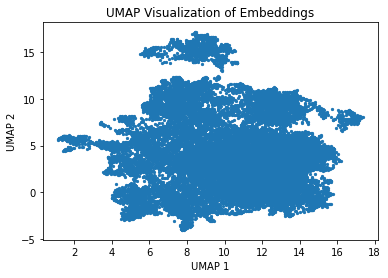

In [52]:
# Run UMAP to reduce dimensionality
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.5).fit_transform(embeddings)

# Plot the UMAP visualization
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=5)
plt.title('UMAP Visualization of Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

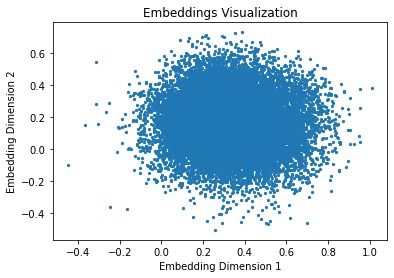

In [57]:
# Extract the X and Y coordinates from the embeddings
x = embeddings[:, 0]
y = embeddings[:, 1]

# Create a scatter plot of the embeddings
plt.scatter(x, y, s=5)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Embeddings Visualization')
plt.show()